# GloVe-V Tutorial

In this tutorial, we walk through how to download our data products from the HuggingFace repository (reglab/glove-v) using this Python library, how to load the GloVe embeddings and GloVe-V variances from these downloaded files, and how to use these data products to perform downstream tasks.


In [1]:
# Set up environment
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image

import glove_v

/Users/avaimar/Documents/Projects/Legal-NLP/glove-v/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Downloading GloVe embeddings and GloVe-V variances

We start by downloading the GloVe-V embeddings for the Toy-Embeddings corpus. This contains the embeddings and the variances for a subset of 11 words from the COHA (1900-1999) corpus. This subset of words was used in the nearest neighbors application from Figure 5 of the GloVe-V paper.


Let $V$ be the size of the vocabulary and $D$ be the embedding dimension. While GloVe embeddings only require storing $V \times D$ floating point numbers, the GloVe-V variances require storing $V \times (D x D)$ floating point numbers. For this reason, we offer two download options:

1. **Approximation Variances**: These are approximations to the full GloVe-V variances that can use either a diagonal approximation to the full variance, or a low-rank Singular Value Decomposition (SVD) approximation. We optimize this approximation at the level of each word to guarantee at least 90% reconstruction of the original variance. These approximations require storing much fewer floating point numbers than the full variances.
2. **Complete Variances**: These are the full GloVe-V variances, which require storing $V \times (D x D)$ floating point numbers. For example, in the case of the 300-dimensional embeddings for the COHA (1900-1999) corpus, this would be approximately 6.4 billion floating point numbers! 

When downloading the data for chosen embeddings, we can choose between these two options using the `approximation` keyword argument. Since the toy embeddings are small, we will download both the approximation and complete variances to compare the approximation's reconstruction error, but in the case of large embeddings, the approximation variances are a more lightweight alternative.


In [3]:
glove_v.data.download_embeddings(
    embedding_name="Toy-Embeddings",
    approximation=True,
)

[INFO] Downloaded vocab.txt: /Users/avaimar/Documents/Projects/Legal-NLP/glove-v/data/glove-v/Toy-Embeddings/vocab.txt
[INFO] Downloaded vectors.safetensors: /Users/avaimar/Documents/Projects/Legal-NLP/glove-v/data/glove-v/Toy-Embeddings/vectors.safetensors
[INFO] Downloading file containing approximated variances.
[INFO] Downloaded ApproximationVariances.safetensors: /Users/avaimar/Documents/Projects/Legal-NLP/glove-v/data/glove-v/Toy-Embeddings/ApproximationVariances.safetensors
[INFO] Downloaded approx_info.txt: /Users/avaimar/Documents/Projects/Legal-NLP/glove-v/data/glove-v/Toy-Embeddings/approx_info.txt


In [4]:
glove_v.data.download_embeddings(
    embedding_name="Toy-Embeddings",
    approximation=False,
)

[INFO] vocab.txt already exists in /Users/avaimar/Documents/Projects/Legal-NLP/glove-v/data/glove-v/Toy-Embeddings
[INFO] vectors.safetensors already exists in /Users/avaimar/Documents/Projects/Legal-NLP/glove-v/data/glove-v/Toy-Embeddings
[INFO] Downloading file containing complete variances.


## 2. Loading GloVe-V embeddings and variances

The vocabulary and vector files are the same regardless of the approximation choice. For the vector file, we can load the data in a dictionary format, where the keys are the words and the values are the vectors. Note that these embeddings are the center vectors provided by the GloVe model, rather than the average of the center and context vectors.

In [8]:
vocab, ivocab = glove_v.vector.load_vocab(
    embedding_name="Toy-Embeddings",
)

In [9]:
vectors = glove_v.vector.load_vectors(
    embedding_name="Toy-Embeddings", format="dictionary"
)

We now load the approximated and complete variances for comparison.

In [10]:
approx_variances = {}
for word in list(vocab.keys()):
    approx_variances[word] = glove_v.variance.load_variance(
        embedding_name="Toy-Embeddings",
        approximation=True,
        word_idx=vocab[word],
    )

In [6]:
variances = {}
for word in list(vocab.keys()):
    variances[word] = glove_v.variance.load_variance(
        embedding_name="Toy-Embeddings",
        approximation=False,
        word_idx=vocab[word],
    )

Notice that the approximated variance for the word "doctor" is a diagonal approximation to the full variance, which recovers 95% of the complete variance.

In [7]:
print('\nComplete Variance for the word "doctor":')
print(variances["doctor"][:3, :3])

print('\nApproximation Variance for the word "doctor":')
print(approx_variances["doctor"][:3, :3])


def frob_norm_prop(a, b):
    return np.linalg.norm(a, "fro") / np.linalg.norm(b, "fro")


prop_reconstruction = (
    frob_norm_prop(approx_variances["doctor"], variances["doctor"]) * 100
)
print(
    f"\nApproximation variance recovers {prop_reconstruction:.2f}% of the complete variance."
)


Complete Variance for the word "doctor":
[[ 3.4058138e-04  4.9981973e-06 -5.0400495e-06]
 [ 4.9981973e-06  3.1099434e-04  1.2308882e-06]
 [-5.0400495e-06  1.2308882e-06  3.2842605e-04]]

Approximation Variance for the word "doctor":
[[0.00034058 0.         0.        ]
 [0.         0.00031099 0.        ]
 [0.         0.         0.00032843]]

Approximation variance recovers 95.11% of the complete variance.


## 3. Using GloVe-V embeddings and variances for downstream tasks: an illustration from the GloVe-V paper
In this section, we will replicate the nearest neighbors application from Figure 5 of the GloVe-V paper using both the approximated and complete variances. This application computed the cosine similarity between the embeddings of the words "doctor" and those of other medical occupations, and propagated the uncertainty from the embeddings to the cosine similarity using the Delta Method.

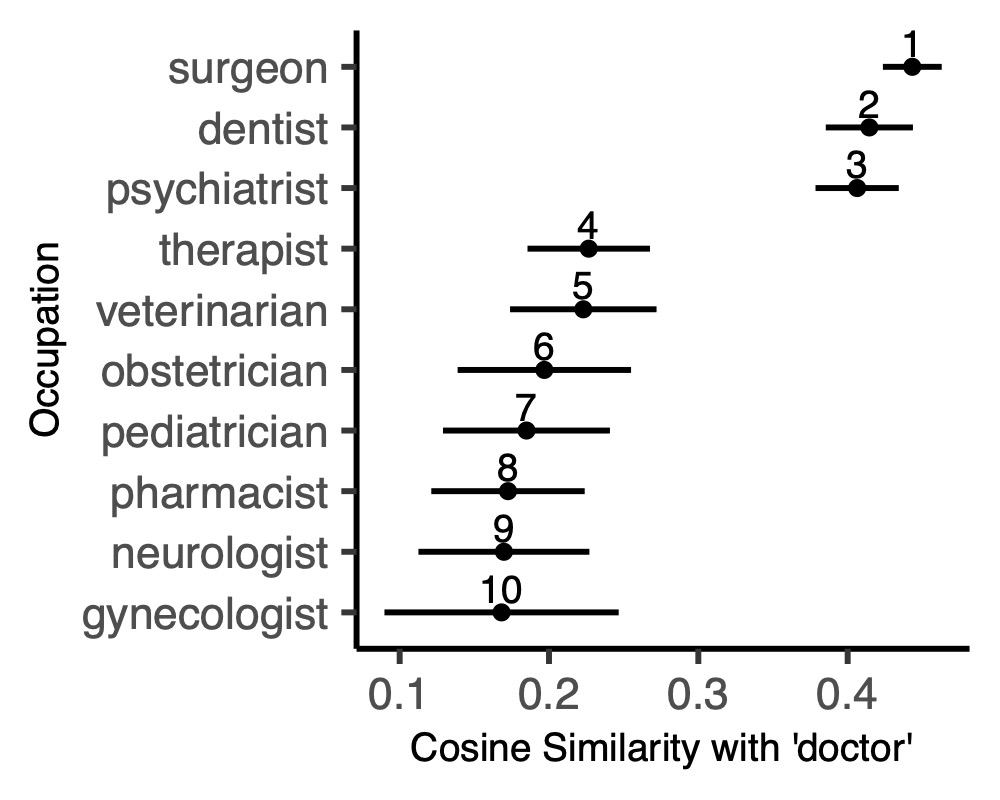

In [8]:
file_path = Path(glove_v.utils.file.get_data_path()) / ".." / "figures" / "figure5.jpg"
Image(file_path, width=300, alt="Figure 5 from the GloVe-V paper")

To apply the Delta Method, we first compile a dictionary of derivatives for the cosine similarity between the embeddings of the words "doctor" and those of other medical occupations. In our Python package, we already provide an implementation for the derivative of the cosine similarity between two vectors (see `glove_v.propagate.cosine_derivative`). Then, we then use these derivatives to compute a distribution for each of these cosine similarities, which we can use to perform statistical inference. For a more detailed explanation of the Delta Method, and its comparison to the Method of Composition, see the "Delta Method vs. Method of Composition" tutorial located at [glove-v/docs/DM_vs_MOC.ipynb](https://github.com/reglab/glove-v/docs/DM_vs_MOC.ipynb).

In [9]:
occupations = [w for w in vocab.keys() if w != "doctor"]

results = pd.DataFrame()
for variance_dict, variance_name in zip(
    [approx_variances, variances], ["Approximation", "Complete"], strict=True
):
    for occupation in occupations:
        # Point estimate
        w_vec = vectors["doctor"]
        c_vec = vectors[occupation]
        cs_estimate = np.matmul(w_vec, c_vec.T) / (
            np.linalg.norm(w_vec) * np.linalg.norm(c_vec)
        )

        # Dictionary of derivatives
        deriv_dict = {}
        for w in ["doctor", occupation]:
            w_vec = vectors[w]
            other_w = "doctor" if w == occupation else occupation
            c_vec = vectors[other_w]
            w_der = glove_v.propagate.cosine_derivative(u=w_vec, v=c_vec)
            deriv_dict[w] = w_der.reshape(1, -1)

        # Delta method variance
        cs_variance = glove_v.propagate.delta_method_variance(
            deriv_dict=deriv_dict,
            variance_dict=variance_dict,
        )

        # Compute 95% confidence intervals for a Normal distribution
        cs_lower, cs_upper = glove_v.propagate.compute_normal_confint(
            point_estimate=cs_estimate, variance=cs_variance, alpha=0.05
        )

        w_results = pd.DataFrame.from_dict(
            {
                "Occupation": [occupation],
                "Variance Type": [variance_name],
                "Estimate": [cs_estimate],
                "Variance": [cs_variance],
                "Lower": [cs_lower],
                "Upper": [cs_upper],
            }
        )
        results = pd.concat([results, w_results], ignore_index=True)

In the figure below, the right-hand plot uses the complete variances, which matches the results we present in Figure 5 of the GloVe-V paper. The left-hand plot uses the approximation variances. We can see that though these slightly underestimate the uncertainty, they still allow us to draw the same conclusions.

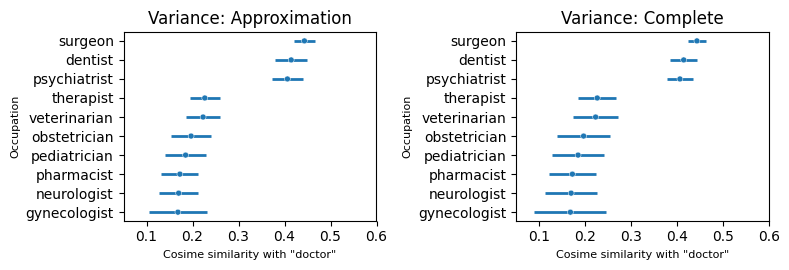

In [36]:
fig, axs = plt.subplots(figsize=(8, 2.8), nrows=1, ncols=2)

for ax, variance_type in zip(axs, ["Approximation", "Complete"], strict=True):
    ax.set_title(f"Variance: {variance_type}")
    sub_results = results[results["Variance Type"] == variance_type].copy()
    ax.errorbar(
        ls="none",
        y=sub_results["Occupation"],
        x=sub_results["Estimate"],
        xerr=(
            np.abs(sub_results["Lower"] - sub_results["Estimate"]),
            np.abs(sub_results["Upper"] - sub_results["Estimate"]),
        ),
        zorder=1,
        linewidth=2,
    )
    sns.scatterplot(
        ax=ax,
        data=sub_results,
        y="Occupation",
        x="Estimate",
        zorder=5,
        size=1,
        legend=False,
    )

    ax.set_ylabel("Occupation", fontsize=8)
    ax.set_xlabel('Cosime similarity with "doctor"', fontsize=8)

    ax.set_xlim((0.05, 0.6))
fig.tight_layout()

## 4. GloVe-V integration with Gensim

The Gensim library is a popular Python library for working with word embeddings. We provide a wrapper for the Gensim API that allows you to easily download and use GloVe-V embeddings and variances with Gensim. In this way, you can use gensim functionality (e.g. `most_similar`) and compute uncertainty estimates on these downstream tasks.

We can download the vectors directly in Gensim format:

In [2]:
gensim_vectors = glove_v.vector.load_vectors(
    embedding_name="Toy-Embeddings", format="gensim"
)

In [3]:
gensim_vectors.most_similar("doctor")

[('surgeon', 0.443281888961792),
 ('dentist', 0.4145265519618988),
 ('psychiatrist', 0.4063537120819092),
 ('therapist', 0.22661727666854858),
 ('veterinarian', 0.22298000752925873),
 ('obstetrician', 0.19687847793102264),
 ('pediatrician', 0.18491394817829132),
 ('pharmacist', 0.17255671322345734),
 ('neurologist', 0.1698257327079773),
 ('gynecologist', 0.16823916137218475)]

Alternatively, if we are using the associated variances to compute uncertainty estimates, we can load them into a `GloVeVKeyedVectors` object:

In [2]:
gensim_glovev_kv = glove_v.GloVeVKeyedVectors(
    embedding_name="Toy-Embeddings",
)

And compute uncertainty on downstream tasks performed with Gensim as follows:

In [5]:
K = 100
sampled_vectors = gensim_glovev_kv.sample_vectors(
    approximation=False,
    verbose=True,
    store=True,
    sample_size=K,
)
similarities = []
for sampled_vector in sampled_vectors:
    # Use Gensim's similarity function
    similarities.append(sampled_vector.similarity("doctor", "surgeon"))


print(f"Mean similarity: {np.mean(similarities)}")
print(f"95% CI: {np.percentile(similarities, [2.5, 97.5])}")

Loading variances: 100%|██████████| 11/11 [00:00<00:00, 342.52it/s]


Mean similarity: 0.4312233890766127
95% CI: [0.41453011 0.45168073]
